<a href="https://colab.research.google.com/github/luthierman/quantum-research-colab/blob/main/DQN_torch_ultimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install autoray==0.2.5
!pip install pennylane
!pip install wandb

     |████████████████████████████████| 914 kB 5.5 MB/s 
     |████████████████████████████████| 1.6 MB 39.5 MB/s 
     |████████████████████████████████| 8.8 MB 15.1 MB/s 
     |████████████████████████████████| 108 kB 49.4 MB/s 
  Attempting uninstall: autoray
    Found existing installation: autoray 0.2.5
    Uninstalling autoray-0.2.5:
      Successfully uninstalled autoray-0.2.5
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 145 kB 54.5 MB/s 
     |████████████████████████████████| 181 kB 62.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=450320474695a9ad10cafca658669400482bf02b4f5be546800f7caf0ecd72f3
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
# %%writefile experience_replay.py
from collections import namedtuple,deque
import random
import numpy as np
import pandas as pd
import torch
class ER_Memory(object):
    def __init__(self, capacity, device="cpu"):
        self.capacity = capacity
        self.device = device
        self.states = torch.zeros((capacity, 4), dtype=torch.float32, device=self.device)
        self.actions = torch.zeros((capacity,1), dtype=torch.int64,device=self.device)
        self.rewards = torch.zeros((capacity,1), dtype=torch.int64,device=self.device)
        self.next_states = torch.zeros((capacity, 4), dtype=torch.float32,device=self.device)
        self.dones = torch.zeros(capacity, dtype=torch.int64,device=self.device)
        self.index = 0
        self._len = 0

    def remember(self, *args):
        exp = [*args]
        self.states[self.index] = torch.from_numpy(exp[0])
        self.actions[self.index] = int(exp[1])
        self.rewards[self.index] = exp[2]
        self.next_states[self.index] = torch.from_numpy(exp[3])
        self.dones[self.index] = exp[4]
        self.index = (self.index+1)%self.capacity
        self._len = min(self._len+1, self.capacity)

    def sample(self, batch_size):
        batch_idxs= np.random.choice(np.arange(self._len), size=min(self._len, batch_size), replace=True)
        return self.states[batch_idxs], self.actions[batch_idxs], self.rewards[batch_idxs], self.next_states[batch_idxs], self.dones[batch_idxs]

    def __len__(self):
      return self._len

    def save(self, path):
      d = {"states": self.states,
           "actions":self.actions,
           "next_states": self.next_states,
           "rewards": self.rewards,
           "dones": self.dones,
           "index": self.index}
      torch.save(d,path)

    def load(self,path):
      d = torch.load(path,map_location=self.device)
      self.states = d["states"]
      self.actions = d["actions"]
      self.next_states = d["next_states"]
      self.rewards = d["rewards"]
      self.dones = d["dones"]
      self.index = d["index"]

    def show(self):
      df =  pd.DataFrame()
      df["states"]= list(self.states.numpy())
      df["actions"]= self.actions.numpy()
      df["rewards"]= self.rewards.numpy()
      df["next_states"] = list(self.next_states.numpy())
      df["dones"] = self.dones.numpy()
      return df

class PER_Memory(object):
    def __init__(self, capacity, device="cpu"):
        self.e = 0.1
        self.alpha = 0.6
        self.beta = 0.4
        self.beta_per = 0.01
        self.capacity = capacity
        self.device = device
        self.states = torch.zeros((capacity, 4), dtype=torch.float32, device=self.device)
        self.actions = torch.zeros((capacity,1), dtype=torch.int64,device=self.device)
        self.rewards = torch.zeros((capacity,1), dtype=torch.int64,device=self.device)
        self.next_states = torch.zeros((capacity, 4), dtype=torch.float32,device=self.device)
        self.dones = torch.zeros(capacity, dtype=torch.int64,device=self.device)
        self.priorities = torch.zeros((capacity,1), dtype=torch.float32,device=self.device)
        self.index = 0
        self._len = 0
        
    def remember(self, *args):
        exp = [*args]
        self.states[self.index] = torch.from_numpy(exp[0])
        self.actions[self.index] = int(exp[1])
        self.rewards[self.index] = exp[2]
        self.next_states[self.index] = torch.from_numpy(exp[3])
        self.dones[self.index] = exp[4]
        self.priorities[self.index] = max(self.priorities.max(), 1)
        self.index = (self.index+1)%self.capacity
        self._len = min(self._len+1, self.capacity)

    def get_probabilities(self):
        scaled_priorities = self.priorities.pow(self.alpha)
        sample_probabilities = scaled_priorities/ torch.sum(scaled_priorities)
        return sample_probabilities

    def get_importance(self, probabilities):
        importance = (1/self._len) * (1/probabilities)
        importance_normalized = importance / np.max(importance)
        return importance_normalized

    def sample(self, batch_size):
        sample_probs = self.get_probabilities()[:self._len].detach().numpy().flatten()
        batch_idxs = np.random.choice(np.arange(self._len),
                                      size=min(self._len, batch_size),
                                      p=sample_probs, replace=True)
        minibatch = self.states[batch_idxs], self.actions[batch_idxs], self.rewards[batch_idxs], self.next_states[batch_idxs], self.dones[batch_idxs]
        w = self.get_importance(sample_probs[batch_idxs])
        return batch_idxs, minibatch,  w

    def __len__(self):
        return self._len

    def update_priorities(self, indices, priorities):
        clipped_errors = np.minimum(priorities.detach().numpy(), 1.0)
        ps = np.power(clipped_errors, self.alpha)
        for i,p in zip( indices, ps):
          self.priorities[i]= p+self.e
  
    def show(self):
        df =  pd.DataFrame()
        df["states"]= list(self.states.numpy())
        df["actions"]= self.actions.numpy()
        df["rewards"]= self.rewards.numpy()
        df["next_states"] = list(self.next_states.numpy())
        df["dones"] = self.dones.numpy()
        df["priorities"] = self.priorities.numpy()
        return df

    def save(self, path):
        d = {"states": self.states,
            "actions":self.actions,
            "next_states": self.next_states,
            "rewards": self.rewards,
            "dones": self.dones,
            "index": self.index,
            "priorities": self.priorities}
        torch.save(d,path)

    def load(self,path):
        d = torch.load(path,map_location=self.device)
        self.states = d["states"]
        self.actions = d["actions"]
        self.next_states = d["next_states"]
        self.rewards = d["rewards"]
        self.dones = d["dones"]
        self.index = d["index"]
        if "priorities" in d.keys():
          self.priorities = d["priorities"]
        else: 
          for i in range(self.index):
            self.priorities[i] = 1


In [4]:
# %%writefile dense_net_per.py
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F

class Dense_Net(nn.Module):
    def __init__(self, n_layers=5):
        super(Dense_Net, self).__init__()
        self.linear_in = nn.Linear(4, 64)
        self.layers = nn.ModuleList()

        for i in range(n_layers-2):
          self.layers.append(nn.Linear(64, 64))
       
        self.linear_out = nn.Linear(64,2)
        nn.init.xavier_normal_(self.linear_in.weight)
        for l in self.layers:
          nn.init.xavier_normal_(l.weight)
        nn.init.xavier_normal_(self.linear_out.weight)

    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for l in self.layers:
          x = F.relu(l(x))
        x = self.linear_out(x)
        return x

In [5]:
import pennylane as qml
from pennylane import numpy as np
from torch import nn
import torch
import matplotlib.pyplot as plt

class Reupload_Net(nn.Module):
    def __init__(self, n_layers=3, n_qubits=4):
      super(Reupload_Net, self).__init__()
      self.n_layers = n_layers
      self.n_qubits = n_qubits
      self.weight_shapes = {"weights": (self.n_layers, self.n_qubits, 3), "w_in": (self.n_layers,self.n_qubits)}
      dev = qml.device("default.qubit.autograd", wires=self.n_qubits)
      def layer( W):
        for i in range(self.n_qubits):
          qml.RY(W[i,1], wires=i)
          qml.RZ(W[i,2], wires=i)
      @qml.qnode(dev, interface='torch', diff_method="adjoint")
      def circuit(weights, inputs, w_in):
          # W: Layer Variable Parameters, s: State Variable
          for i in range(self.n_layers):
            # Weighted Input Encoding
            qml.AngleEmbedding(torch.tanh(torch.multiply(inputs,w_in[i])), wires=range(self.n_qubits), rotation="X")
            # Parameterized Layer
            layer(weights[i])
            # Entangling
            for j in range(n_qubits):
                qml.CNOT(wires=[j%self.n_qubits,(j+1)%self.n_qubits])
          return [qml.expval(qml.PauliZ(0)@qml.PauliZ(1)), qml.expval(qml.PauliZ(2)@qml.PauliZ(3))]
      self.qvc = qml.qnn.TorchLayer(circuit, self.weight_shapes)
      nn.init.uniform(self.qvc.weights, a=0, b=torch.pi)
      d = self.qvc.state_dict()
      d["w_in"] =torch.autograd.Variable(torch.ones(n_layers,n_qubits,requires_grad=True))
      self.w_out = nn.Parameter(torch.ones(1,2),requires_grad=True)
      self.qvc.load_state_dict(d)
      # W = torch.DoubleTensor(self.n_layers,self.n_qubits,3)
      # ins = torch.ones(self.n_layers)
      # qml.drawer.use_style("black_white_dark")
      # self.fig, self.ax = qml.draw_mpl(circuit,fontsize="xx-large")(weights=W , inputs=torch.tensor([[0,0,0,0]]) ,w_in=ins)
      # self.fig.show()   
    def forward(self, x):
      # rescaled out 
      out =  (self.qvc(x)+1)/2
      return torch.mul(out, self.w_out)

      
    def save_visual(self,path):
      self.fig.savefig(path)

Reupload_Net(5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


Reupload_Net(
  (qvc): <Quantum Torch Layer: func=circuit>
)

In [6]:
# %%writefile hyperparameters.py

LR = 0.001
GAMMA = 0.95
EPSILON = 1.0
EPSILON_DECAY= 0.99
EPSILON_MIN = 0.01
N_EPISODES = 100
BATCH_SIZE = 16
BUFFER_SIZE = 10000
UPDATE_TARGET = 10
UPDATE_MODEL = 1
TRAIN_START = 1
is_DDQN = False
use_PER = False
constrain = False # the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
# the episode terminates if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

In [7]:
from copy import copy
import gym
import matplotlib.pyplot as plt
from torch.optim import *
from collections import deque
import random
import numpy as np
import os
import time
import datetime
from pathlib import Path
import wandb

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

class DQN(object):
    def __init__(self, model, config, name, use_wandb=False, env="CartPole-v0") -> None:
        # GYM environment
        self.name =name
        self.use_wandb =use_wandb
        if self.use_wandb:
          self.run = wandb.init(project="quantum_research", 
                 entity="luthier-man",
                 name=self.name,
                 config=config,
                 monitor_gym=True,
                 save_code=True, reinit=True)
          self.run.log_code(".")
          
          self.run.define_metric("Train Episode", hidden=True)
          self.run.define_metric("Test Episode", hidden=True)

          self.run.define_metric("Average Loss Per Episode","Train Episode")
          self.run.define_metric("Running Average Rewards (50)","Train Episode")
          self.run.define_metric("Q-values","Train Episode")
          self.run.define_metric("Average Q-values","Train Episode")

          self.run.define_metric("Episode Time", "Train Episode")
          self.run.define_metric("Total Train Rewards", "Train Episode")
          self.run.define_metric("Total Test Rewards", "Test Episode")

        self.env = gym.make(env)
        self.action_space = self.env.action_space.n
        self.state_space = self.env.observation_space.shape[0]
        print("State Space: {}".format(self.state_space))
        print("Action Space: {}".format(self.action_space))
        
        # HYPERPARAMETERS
        self.config = config
        print(config)
        self.lr = self.config["learning_rate"]
        self.gamma = self.config["gamma"]
        self.epsilon = self.config["epsilon"]
        self.epsilon_decay = self.config["epsilon_decay"]
        self.epsilon_min = self.config["epsilon_min"]
        self.batch = self.config["batch_size"]
        self.episodes = self.config["n_episodes"]
        self.buff = self.config["buffer_size"]
        self.update_target = self.config["update_target"]
        self.update_model = self.config["update_model"]
        self.train_start = self.config["train_start"]
        self.ddqn= self.config["is_DDQN"]
        self.use_per = self.config["use_PER"]
        self.reupload= self.config["is_Reupload"]
        self.n_layers = self.config["n_layers"]
        self.constrain = self.config["constrain"]

        use_cuda = False
        
        self.device = torch.device("cuda" if use_cuda else "cpu")
        
        # Q-network
        self.q_network = model(self.n_layers)
        self.q_network_test = model(self.n_layers)

        # Quantum Reupload prep
        if self.reupload:
          self.lr_in = self.config["learning_rate_in"]
          self.lr_out = self.config["learning_rate_out"]
          self.param_in = [self.q_network.qvc.w_in]
          self.param_weights = [self.q_network.qvc.weights]
          self.param_out = [self.q_network.w_out]
          self.opt_in =Adam(self.param_in, lr=self.lr_in,amsgrad=True)
          self.opt_var =Adam(self.param_weights,lr=self.lr,amsgrad=True)
          self.opt_out =Adam(self.param_out, lr=self.lr_out,amsgrad=True)
        else:
          self.opt = Adam(self.q_network.parameters(),lr=self.lr,amsgrad=True)
        # Target network
        self.target = model(self.n_layers)
        self.sync_weights()
        # GPU setup

        if use_cuda:
            print("GPU being used:", torch.cuda.get_device_name(0))
            self.q_network.cuda(self.device)
            self.target.cuda(self.device)
        self.target.eval()
        
        # DQN setup
        self.loss_fn = torch.nn.MSELoss()
        if self.use_wandb:
          self.run.watch(self.q_network, log="all",log_freq=1,
            criterion=self.loss_fn, log_graph=True)
        if self.use_per:
          self.memory = PER_Memory(self.buff)
        else:
          self.memory = ER_Memory(self.buff)
        self.counter = 0
        self.step = 0
        self.current_episode = 0
        # stat tracking
        self.rewards = []
        self.avg_rewards = []
        self.losses = []
        self.q_values = []

        self.test_rewards = []
        self.test_avg_rewards = []
        self.test_q_values = []

        self.name = name
        self.path = "{}_logs".format(self.name)
        self.save_path = "{}/{}_ep_{}.pt".format(self.path,self.name,self.current_episode+1)
        os.makedirs(self.path, exist_ok=True)
        
    def preprocess_state(self,x):
        x = np.stack(x)
        state = torch.FloatTensor(x).to(self.device)
        return state
    
    def sync_weights(self):
        self.target.load_state_dict(self.q_network.state_dict())

    def sync_weights_test(self):
        self.q_network_test.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.remember(state, action, reward, next_state, done)
        self.counter += 1

    def get_action(self, obs, is_test=False):
        if is_test:
            self.q_network_test.eval()
            obs = self.preprocess_state([obs])
            return int(self.q_network_test(obs).argmax().detach())
        if len(self.memory) > self.batch:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        if np.random.random() <= self.epsilon:
            return self.env.action_space.sample()
        else:
            self.q_network.eval()
            obs = self.preprocess_state([obs])
            return int(self.q_network(obs).argmax().detach())

    def learn(self):
        if len(self.memory) < self.train_start:
            return 0
        if self.use_per:
          idx, minibatch, ws = self.memory.sample(self.batch)
        else: 
          minibatch = self.memory.sample(min(len(self.memory), self.batch))
        states, actions, rewards, next_states, dones = minibatch
        self.q_network.train()
        self.target.eval()
        # DDQN
        if self.ddqn:
          Q = self.q_network.forward(states).gather(1, actions).squeeze(-1)# Q(s, a, wq)
          A_best = self.q_network.forward(next_states).argmax(1).reshape(-1,1) # 
          Q_next = self.target.forward(next_states).gather(1, A_best).squeeze(-1) # max _a Q(ns, argmax_a(Q(ns, a, wq)) , wt)
        # DQN
        else:
          Q = self.q_network.forward(states).gather(1, actions).squeeze(-1)# Q(s, a, wq)
          Q_next = self.target.forward(next_states).max(1)[0].detach() # max _a Q(ns, a, wt)
        y = torch.flatten(rewards) + self.gamma *(1-torch.flatten(dones)) * Q_next # bellman 
        if self.use_per:
          # PER
          error = torch.absolute(y-Q)
          self.memory.update_priorities(idx, error)
          # REUPLOAD QVC
          if self.reupload:
            self.opt_in.zero_grad(set_to_none=True)
            self.opt_var.zero_grad(set_to_none=True)
            self.opt_out.zero_grad(set_to_none=True)
            loss = torch.multiply((error).pow(2),self.preprocess_state(ws).pow(1-self.epsilon))
            loss=loss.mean()
            loss.backward()
            self.opt_in.step()
            self.opt_var.step()
            self.opt_out.step()
          # Regular optimization
          else:
            self.opt.zero_grad(set_to_none=True)
            loss = torch.multiply((error).pow(2),self.preprocess_state(ws))
            loss=loss.mean()
            loss.backward()
            self.opt.step()
        # ER
        else:
          # REUPLOAD QVC
          if self.reupload:
            self.opt_in.zero_grad(set_to_none=True)
            self.opt_var.zero_grad(set_to_none=True)
            self.opt_out.zero_grad(set_to_none=True)
            loss = self.loss_fn(Q,y)
            loss.backward()
            self.opt_in.step()
            self.opt_var.step()
            self.opt_out.step()
          # Regular optimization
          else:
            self.opt.zero_grad(set_to_none=True)
            loss = self.loss_fn(Q,y)
            loss.backward()
            self.opt.step()
        return float(loss), Q.detach().numpy().flatten()
    
    def load(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.sync_weights()

    def train(self, episodes=None):
        alert=True
        if episodes == None:
          episodes = self.episodes
        start_episode = self.current_episode
        episodes +=start_episode
        
        for t in range(start_episode, episodes):
          start_time = time.time()
          s1 = self.env.reset()
          steps = 1
          train_steps = 0
          done = False
          total_reward = 0
          total_loss = [] 
          total_q = []
          while not done:
              # self.env.render()
              action = self.get_action(s1)
              s2, reward, done, _ = self.env.step(action)
              total_reward+=reward
              if self.constrain:
                if np.abs(s2[0]) > 1.4 or np.abs(s2[2]) > .1:
                  done = True
              self.remember(s1,action,reward,s2,done)
              if done:
                  episode_time = time.time() - start_time
                  # Store Trackable Stats
                  self.rewards.append(total_reward),
                  avg = np.mean(self.rewards[-50:])
                  losses = np.asarray(total_loss)
                  qs = np.asarray(total_q).flatten()
                  if train_steps!=0:
                    self.losses.append(losses.mean())
                    self.q_values.append(qs)
                  else:
                    self.losses.append(0)
                    self.q_values.append(0)
                  self.avg_rewards.append(avg)
                  print("\rTRAIN: Episode {c_ep}/{n_ep} [{t} sec.]|| 50 Running Avg {a}, Episode Reward {tr}, Loss {l}, Q {q}, eps {eps}".format(
                        c_ep=self.current_episode+1,
                        n_ep=episodes,
                        t= np.round(episode_time, 3),
                        a=np.round(avg, 3),
                        tr=np.round(total_reward, 3),
                        l=np.round(self.losses[self.current_episode], 3),
                        q=np.round(qs.mean(),3),
                        eps=np.round(self.epsilon, 3)
                    ),flush=True, end="")
                  self.save_path = "{}/{}_ep_{}.pt".format(self.path,self.name,self.current_episode+1)
                  self.memory.save("{}/{}_memory.pt".format(self.path,self.name))
                  torch.save(self.q_network.state_dict(), self.save_path)
                  if self.use_wandb:
                    if self.rewards[t]==200 and alert:
                      wandb.alert(title="Reached 200", 
                      text="{} Agent has reached 200 points!!!".format("DQN Classical ER"))
                    alert= False
                    self.run.log({"Total Train Rewards":self.rewards[t],
                      "Average Loss Per Episode": self.losses[t],
                      "Running Average Rewards (50)": self.avg_rewards[t],
                      "Q-values": wandb.Histogram(self.q_values[t]),
                      "Average Q-values": qs.mean(),
                      "Episode Time":episode_time,
                      "Train Episode": t})
                    self.run.save("{}/*pt".format(self.path))
                  self.current_episode+=1
                  break
              s1 = s2
              if self.counter%self.update_model==0:
                loss, q = self.learn()
                if loss != None:
                    total_loss.append(loss)
                    for j in q:
                      total_q.append(j)
                    train_steps+=1
              if self.counter %self.update_target==0:
                  self.sync_weights()
              steps+=1
          
    def test(self,episodes=None):
        self.test_rewards = []
        self.test_avg_rewards = []
        self.test_q_values = []
        self.sync_weights_test()
        if episodes == None:
          episodes = self.episodes
        for t in range(episodes):
          start_time = time.time()
          s1 = self.env.reset()
          steps = 1
          done = False
          total_reward = 0
          while not done:
              # self.env.render()
              action = self.get_action(s1, is_test=True)
              s2, reward, done, _ = self.env.step(action)
              total_reward+=reward
              if done:
                  episode_time = time.time() - start_time
                  # Store Trackable Stats
                  self.test_rewards.append(total_reward),
                  avg = np.mean(self.test_rewards[-50:])
                  self.test_avg_rewards.append(avg)
                  print("\rTEST: Episode {c_ep}/{n_ep} [{t} sec.]|| 50 Running Avg {a}, Episode Reward {tr}, eps {eps}".format(
                        c_ep=t+1,
                        n_ep=episodes,
                        t= np.round(episode_time, 3),
                        a=np.round(avg, 3),
                        tr=np.round(total_reward, 3),
                        eps=np.round(self.epsilon, 3)
                    ),flush=True, end="")
                  if self.use_wandb:
                    self.run.log({"Total Test Rewards": self.test_rewards[t], "Test Episode": t})
                  break
              s1 = s2
              steps+=1



In [ ]:
## DQN CLASSICAL ER
torch.cuda.empty_cache()
config = {
  "learning_rate": LR,
  "learning_rate_in": .01,
  "learning_rate_out": .1,
  "n_episodes": 200,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": 10000,
  "update_target": 10,
  "update_model": 1,
  "train_start": TRAIN_START,
  "is_DDQN": False,
  "use_PER": False,
  "is_Reupload":False,
  "n_layers":3,
  "constrain": True
}


config["use_PER"] = False
config["is_Reupload"] = True
config["constrain"] = False
agent_qdqn_er_un = DQN(Reupload_Net, config, "Quantum-ER-3-layer-unconstrained",True)
agent_qdqn_er_un.load("model.pt")
agent_qdqn_er_un.memory.load("memory.pt")

agent_qdqn_er_un.train()
agent_qdqn_er_un.test()
agent_qdqn_er_un.run.finish()

In [ ]:
config["use_PER"] = True
config["is_Reupload"] = False
config["constrain"] = True
agent_dqn_per_con = DQN(Dense_Net, config, "Classical-PER-3-layer-constrained", True)
agent_dqn_per_con.train()
agent_dqn_per_con.test()
agent_dqn_per_con.run.finish()


In [ ]:
config["use_PER"] = False
config["is_Reupload"] = False
config["constrain"] = False
agent_dqn_er = DQN(Dense_Net, config, "Classical-ER-3-layer", True)
agent_dqn_er.train()
agent_dqn_er.test()
config["use_PER"] = True
config["is_Reupload"] = False
config["constrain"] = False
agent_dqn_per = DQN(Dense_Net, config, "Classical-PER-3-layer", True)
agent_dqn_per.train()
agent_dqn_per.test()

In [ ]:
config["use_PER"] = False
config["is_Reupload"] = False
config["constrain"] = True
config["is_DDQN"] = True

agent_dqn_er_ddqn = DQN(Dense_Net, config, "Classical-ER-3-layer-DDQN-constrained", True)
agent_dqn_er_ddqn.train()
agent_dqn_er_ddqn.test()
agent_dqn_er_ddqn.run.finish()

config["use_PER"] = True
config["is_Reupload"] = False
config["constrain"] = True
config["is_DDQN"] = True
agent_dqn_per_ddqn = DQN(Dense_Net, config, "Classical-PER-3-layer-DDQN-constrained", True)
agent_dqn_per_ddqn.train()
agent_dqn_per_ddqn.test()
agent_dqn_per_ddqn.run.finish()


In [ ]:
config["use_PER"] = False
config["is_Reupload"] = True
config["constrain"] = True
agent_qdqn_er_con = DQN(Reupload_Net, config, "Quantum-ER-3-layer-constrained", True)
agent_qdqn_er_con.train()
agent_qdqn_er_con.test()
agent_qdqn_er_con.run.finish()

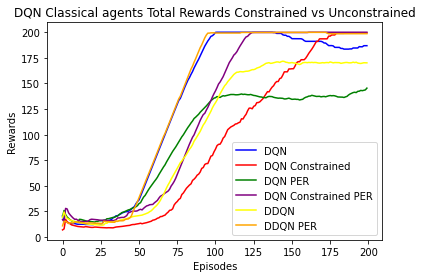

In [14]:
plt.plot(agent_dqn_er.avg_rewards, color='blue', label='DQN')
plt.plot(agent_dqn_er_con.avg_rewards, color='red', label='DQN Constrained')
plt.plot(agent_dqn_per.avg_rewards, color='green', label='DQN PER')
plt.plot(agent_dqn_per_con.avg_rewards, color='purple', label='DQN Constrained PER')
plt.plot(agent_dqn_er_ddqn.avg_rewards, color='yellow', label='DDQN')
plt.plot(agent_dqn_per_ddqn.avg_rewards, color='orange', label='DDQN PER')
plt.title("DQN Classical agents Total Rewards Constrained vs Unconstrained")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend()
plt.show()